In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
class NN(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.full_block = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=185),
            nn.ReLU(),
            nn.Linear(in_features=185, out_features=num_classes)
        )
    
    def forward(self, x):
        return self.full_block(x)
        

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
input_size = 784
num_classes = 10
lr = 0.003069075897562435
batch_size = 64
num_epochs = 3
n_splits = 10

In [15]:
train_dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

In [16]:
train_ds, val_ds = random_split(train_dataset,[50000, 10000])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
model = NN(input_size, num_classes).to(device)

# loss, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
from tqdm.auto import tqdm
for epoch in range(num_epochs):
    model.train()
    for idx, (X, y) in enumerate(tqdm(train_loader)):
        X, y = X.to(device), y.to(device)
        X = X.reshape(X.shape[0], -1)
        # Forward pass
        preds = model(X)
        
        #calculate loss
        loss = criterion(preds, y)
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()
        
        # optimizer step
        optimizer.step()
    print(loss)
        

  0%|          | 0/782 [00:00<?, ?it/s]

tensor(0.0182, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/782 [00:00<?, ?it/s]

tensor(0.1944, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/782 [00:00<?, ?it/s]

tensor(0.2934, device='cuda:0', grad_fn=<NllLossBackward0>)


In [21]:
def check_accuracy(loader, model):
    #acc_fn= torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    num_correct, num_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(loader):
            X, y = X.to(device), y.to(device)
            X = X.reshape(X.shape[0], -1)
            preds = model(X)
            #pr = acc_fn(preds, y) 
            _, predictions = preds.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    model.train()
#     return pr
    return num_correct/num_samples

            
            
        
    

In [22]:
print(f"Accuracy on Training_set {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on Validation_set {check_accuracy(val_loader, model)*100:.2f}")
print(f"Accuracy on Testing_set {check_accuracy(test_loader, model)*100:.2f}")

  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy on Training_set 98.54


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on Validation_set 97.24


  0%|          | 0/157 [00:00<?, ?it/s]

Accuracy on Testing_set 97.61


In [27]:
kf = KFold(n_splits=n_splits, shuffle=True)
fold_losses = []
fold_accuracies = []

for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f"Running fold  {fold+1}/{n_splits}")
    train_ds = torch.utils.data.Subset(train_dataset, train_indices)
    val_ds = torch.utils.data.Subset(train_dataset, val_indices)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    
    model = NN(input_size, num_classes).to(device)

    # loss, optim
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        for idx, (X, y) in enumerate(tqdm(train_loader)):
            X, y = X.to(device), y.to(device)
            X = X.reshape(X.shape[0], -1)
            # Forward pass
            preds = model(X)

            #calculate loss
            loss = criterion(preds, y)

            # optimizer zero grad
            optimizer.zero_grad()

            #loss backward
            loss.backward()

            # optimizer step
            optimizer.step()
    
#     print(f"Accuracy on Training_set {check_accuracy(train_loader, model)*100:.2f}")
    acc = check_accuracy(val_loader, model)*100
    fold_accuracies.append(acc)
    print(f"Accuracy on Validation_set {acc:.2f}")
#     print(f"Accuracy on Testing_set {check_accuracy(test_loader, model)*100:.2f}")
#     print('------------------------------------------------------------------------\n')
        
    
    
    
    

Running fold  1/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.35
Running fold  2/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.08
Running fold  3/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 96.87
Running fold  4/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 96.87
Running fold  5/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.25
Running fold  6/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 96.83
Running fold  7/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.33
Running fold  8/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.22
Running fold  9/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 97.25
Running fold  10/10


  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Accuracy on Validation_set 96.80


In [28]:
fold_accuracies1 = [round(i.item(),2) for i in fold_accuracies]

In [29]:
fold_accuracies1

[97.35, 97.08, 96.87, 96.87, 97.25, 96.83, 97.33, 97.22, 97.25, 96.8]

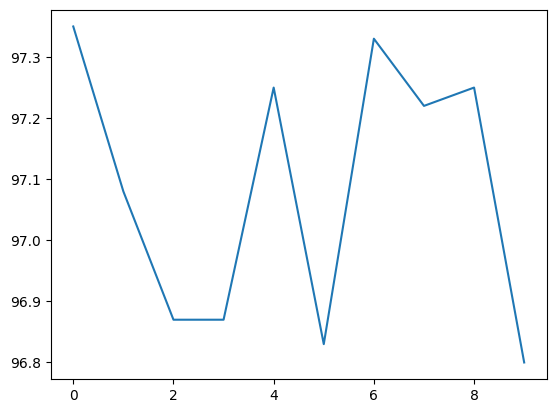

In [30]:
import matplotlib.pyplot as plt
plt.plot(fold_accuracies1)

In [31]:
print(f"AVG = {np.array(fold_accuracies1).mean()}")
print(f"MIN = {np.array(fold_accuracies1).min()}")
print(f"MAX = {np.array(fold_accuracies1).max()}")

AVG = 97.085
MIN = 96.8
MAX = 97.35


In [32]:
import torchmetrics
from torchmetrics import Metric

In [42]:
acc_fn= torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import optuna

# Define the neural network architecture
class NN(nn.Module):
    def __init__(self, in_features, num_classes, n_units):
        super().__init__()
        self.full_block = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_units),
            nn.ReLU(),
            nn.Linear(in_features=n_units, out_features=num_classes)
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.full_block(x)

def objective(trial):
    # Define hyperparameters to optimize
    n_units = trial.suggest_int("n_units", 16, 256, log=True)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Define the model, loss function and optimizer
    model = NN(input_size, num_classes, n_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train and evaluate the model for `num_epochs` epochs
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            trial.report(accuracy, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy

In [8]:
# Define constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 784
num_classes = 10
num_epochs = 3

# Load MNIST dataset
train_dataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

# Define the study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=1)
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-06 07:54:14,160] A new study created in memory with name: no-name-53128fe7-9e46-484e-8818-87eb9ef38fa1
/tmp/ipykernel_31/4083320804.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2023-05-06 07:54:36,004] Trial 0 finished with value: 93.29 and parameters: {'n_units': 16, 'lr': 0.0017079755092667824, 'batch_size': 128}. Best is trial 0 with value: 93.29.
[I 2023-05-06 07:54:59,378] Trial 1 finished with value: 91.44 and parameters: {'n_units': 21, 'lr': 0.00018174154565345793, 'batch_size': 64}. Best is trial 0 with value: 93.29.
[I 2023-05-06 07:55:20,670] Trial 2 finished with value: 95.88 and parameters: {'n_units': 46, 'lr': 0.005131020794756615, 'batch_size': 128}. Best is trial 2 with value: 95.88.
[I 2023-05-06 07:55:42,366] Trial 3 finished w

Best trial:
  Value:  97.64
  Params: 
    n_units: 185
    lr: 0.003069075897562435
    batch_size: 64


In [25]:
trial.params

{'n_units': 185, 'lr': 0.003069075897562435, 'batch_size': 64}

In [26]:
trial.value

97.64

{'n_units': 185, 'lr': 0.003069075897562435, 'batch_size': 64}